In [92]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import re
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


### Clean the scrapping data.

In [10]:
df = pd.read_csv('/Volumes/My Passport SSD/HW2_data', index_col=0)

In [28]:
#corpus pre-processing, including remove the stopwords
from nltk.corpus import stopwords
StopWordslist = stopwords.words("english")

def string_process(s):
    s=str(s)
    lower = s.lower()
    for key, value in model_dict.items():
        lower= lower.replace(key, value)
    words = lower.split()
    refined = []
    for i in words:
        if i not in StopWordslist:
            refined.append(re.sub("[^\w]+", "", i))
    sentence = ' '.join([word for word in refined])
    return(sentence)
df['clean_message']=df['message'].map(string_process)

In [29]:
df.head()

,date,message,userid,clean_message
0,"May 1, 2007 6:44PM",It'll be interesting to see what Honda has up ...,lilengineerboy,itll interesting see honda sleeve 08 honda com...
1,"May 1, 2007 6:45PM",Having seen the spy photos of the Accord Coupe...,thegraduate,seen spy photos honda coupe im gonna go limb s...
2,"May 1, 2007 7:03PM",torque steer and FWD cars is an interesting pr...,captain2,torque steer fwd car interesting problem remem...
3,"May 1, 2007 7:25PM","How funny, I had a '72 Vega as well and I know...",bv050506,funny 72 vega well know mine hatchback 2300cc ...
4,"May 1, 2007 7:33PM","My folks had a Vega too, but that was mostly b...",lilengineerboy,folks vega too mostly existed count list car d...


## Task A

### Get the model -> brand dictionary

In [43]:
# create a dictionary that replace the model names to brand
model_df = pd.read_csv('Cars make model list.csv')
model_df['Replace'] = model_df['Replace'].str.lower()
model_df['Search'] = model_df['Search'].str.lower()
model_dict = model_df.set_index('Search')['Replace'].to_dict()

In [35]:
model_set=set(model_dict.values())-{'car','seat','sedan','problem'}
model_set

{'acura',
 'audi',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'dodge',
 'ford',
 'honda',
 'hyndai kia',
 'hyundai',
 'hyundai,',
 'hyundai.',
 'infiniti',
 'kia',
 'kia.',
 'lincoln',
 'mazda',
 'mercedes',
 'mercedes-benz',
 'mercury',
 'mitsubishi',
 'nissan',
 'nissan.',
 'pontiac',
 'saturn',
 'subaru',
 'suzuki',
 'toyata',
 'toyota',
 'volkswagen',
 'volkwagen',
 'volvo'}

### Get the frequency of brands that mention in the message

In [33]:
# Now, count the the brand name in each message.
count_df=DataFrame(df['clean_message'])
for i in model_set:
    count_df[i]=0

In [34]:
count_df.head()

,clean_message,toyata,subaru,buick,audi,mercury,mitsubishi,chevrolet,ford,suzuki,...,lincoln,acura,nissan,toyota,nissan.,volvo,chrysler,hyundai.,"hyundai,",volkwagen
0,itll interesting see honda sleeve 08 honda com...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,seen spy photos honda coupe im gonna go limb s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,torque steer fwd car interesting problem remem...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,funny 72 vega well know mine hatchback 2300cc ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,folks vega too mostly existed count list car d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
def count_brand():
    for num in range(len(count_df['clean_message'])):
        for i in model_set:
            if i in count_df['clean_message'][num]:
                count_df.loc[num,i]=1
count_brand()

In [41]:
count_df.drop('clean_message',1, inplace=True)
count_df.loc['Row_sum'] = count_df.apply(lambda x: x.sum())
count_series=count_df.T['Row_sum']
count_series.sort_values(ascending=False)[:10]

honda         15
nissan         6
ford           5
toyota         4
acura          3
saturn         2
chevrolet      2
mitsubishi     1
pontiac        1
dodge          1
Name: Row_sum, dtype: int64

### Now, calculate lift ratios for associations between the brands

In [53]:
count_number=count_df.drop('Row_sum')

In [54]:
def lift(a, b):
    total = len(count_number)  #total message
    fraq_a = sum(count_number[a]) # number of message containing A
    fraq_b = sum(count_number[b]) # number of message containing B
    a_b_df=count_number[[a,b]]
    a_b_df['Col_sum'] = a_b_df.apply(lambda x: x.sum(), axis=1)
    fraq_a_b=len(a_b_df[a_b_df['Col_sum']==2]) # number of messages containing both A & B
    if fraq_a_b==0:
        return .1
    return round((total*fraq_a_b*1.0)/(fraq_a*fraq_b*1.0),2) #Lift formula

In [55]:
top_10=set(count_series.sort_values(ascending=False)[:10].index) # top 10 brands by frequency
list_10=list(count_series.sort_values(ascending=False)[:10].index) # in a list form

In [56]:
lift_df=pd.DataFrame(columns=list_10, index=list_10)
for i in list_10:
    for j in list_10:
        lift_df.loc[i,j]=lift(i,j)

In [59]:
lift_df

,honda,nissan,ford,toyota,acura,saturn,chevrolet,mitsubishi,pontiac,dodge
honda,2,1,1.2,1.5,1.33,0.1,0.1,0.1,0.1,0.1
nissan,1,5,1,1.25,0.1,2.5,2.5,0.1,0.1,5
ford,1.2,1,6,3,6,6,6,0.1,6,0.1
toyota,1.5,1.25,3,7.5,2.5,0.1,0.1,0.1,0.1,7.5
acura,1.33,0.1,6,2.5,10,5,5,0.1,10,0.1
saturn,0.1,2.5,6,0.1,5,15,15,0.1,15,0.1
chevrolet,0.1,2.5,6,0.1,5,15,15,0.1,15,0.1
mitsubishi,0.1,0.1,0.1,0.1,0.1,0.1,0.1,30,0.1,0.1
pontiac,0.1,0.1,6,0.1,10,15,15,0.1,30,0.1
dodge,0.1,5,0.1,7.5,0.1,0.1,0.1,0.1,0.1,30


### Show the brands on a multi-dimensional scaling (MDS) map

In [67]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

dissimilarity = 1/ lift_df
adist = np.array(dissimilarity)
amax = np.amax(adist)
adist /= amax # scaling the dissimilarity matrix

mds = MDS(n_components=2,metric=False, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

In [63]:
dissimilarity # this is the dissimilarity matrix 

,honda,nissan,ford,toyota,acura,saturn,chevrolet,mitsubishi,pontiac,dodge
honda,0.5,1,0.833333,0.666667,0.75188,10,10,10,10,10
nissan,1,0.2,1,0.8,10,0.4,0.4,10,10,0.2
ford,0.833333,1,0.166667,0.333333,0.166667,0.166667,0.166667,10,0.166667,10
toyota,0.666667,0.8,0.333333,0.133333,0.4,10,10,10,10,0.133333
acura,0.75188,10,0.166667,0.4,0.1,0.2,0.2,10,0.1,10
saturn,10,0.4,0.166667,10,0.2,0.0666667,0.0666667,10,0.0666667,10
chevrolet,10,0.4,0.166667,10,0.2,0.0666667,0.0666667,10,0.0666667,10
mitsubishi,10,10,10,10,10,10,10,0.0333333,10,10
pontiac,10,10,0.166667,10,0.1,0.0666667,0.0666667,10,0.0333333,10
dodge,10,0.2,10,0.133333,10,10,10,10,10,0.0333333


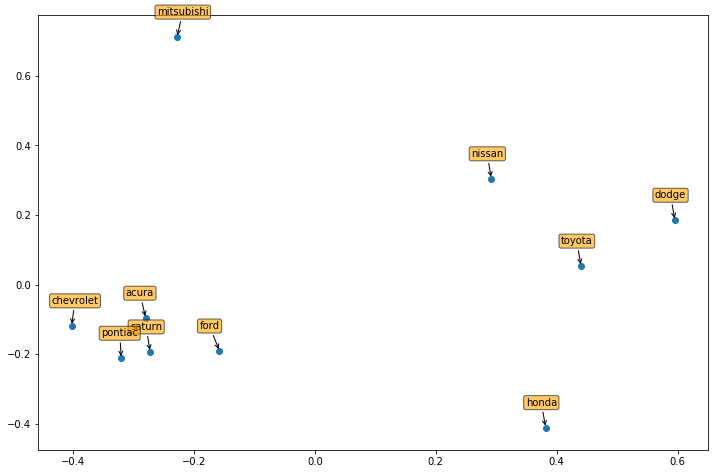

In [88]:
# plot MDS
plt.figure(figsize=(12,8))
plt.scatter(results.embedding_[:,0],results.embedding_[:, 1])

#plot the brand name labels
for label, x, y in zip(dissimilarity.columns.values, results.embedding_[:, 0], results.embedding_[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=.2', fc = 'orange', alpha = 0.6),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

## Task B
What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

## Task C
What are 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

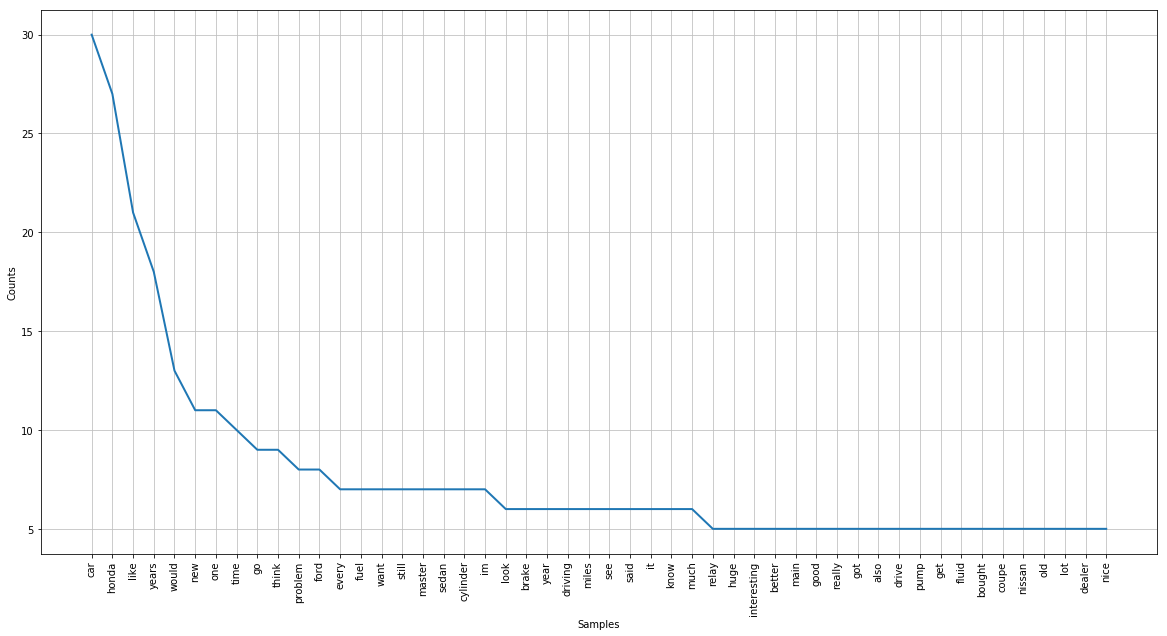

In [99]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

#get full message
full_des = df['clean_message'].sum()

#tokenize the message
des_words = nltk.word_tokenize(full_des)

#get rid of punctuation
des_words = [word for word in des_words if word.isalpha()==True]

#Calculate frequency.
fdist = nltk.FreqDist(des_words)

#Plot the top 100 against Zipf's Law
plt.figure(figsize=(20,10))
fdist.plot(50, cumulative=False)

<FreqDist with 721 samples and 1338 outcomes>
